In [ ]:
pip install --user geopandas
pip install --user descartes

### Read in Data

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import researchpy as rp

from descartes.patch import PolygonPatch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.collections import PatchCollection

In [1]:
listings_detail = pd.read_excel('../CourseProject/data/listings_detail.xlsx', index_col=0)
calendar_detail = pd.read_excel('../CourseProject/data/calendar_detail.xlsx' , index_col=0)
neighbourhoods = pd.read_excel('../CourseProject/data/neighbourhoods.xlsx', index_col=0)
reviews = pd.read_excel('../CourseProject/data/reviews_detail.xlsx', index_col=0)
crime = pd.read_excel('../CourseProject/data/NYPD_Arrests_Data__Historic_.xlsx', index_col=0)
nbgeo = gpd.read_file('../CourseProject/data/neighbourhoods.geojson')
ls=pd.read_csv('../CourseProject/data/listings_summary.csv', index_col=0)

### Data Cleaning
There are many missing values which either need to be removed or estimated so that they do not affect our results

In [2]:
#How many records we start with
print(f'Number of records: {listings_detail.count()[0]}')

Number of records: 44317


In [87]:
#What is missing?
ls.isna().sum()

name                                28
host_id                              0
host_name                          232
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       9440
reviews_per_month                 9474
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [91]:
#What is missing?
listings_detail.isna().sum()

listing_url                             1
scrape_id                               1
last_scraped                            1
name                                   40
summary                              1521
space                               14501
description                            30
experiences_offered                     1
neighborhood_overview               18695
notes                               28202
transit                             16963
access                              19105
interaction                         19941
house_rules                         19177
thumbnail_url                        3306
medium_url                           3306
picture_url                             1
xl_picture_url                       3306
host_id                                 1
host_url                                1
host_name                             232
host_since                            232
host_location                         405
host_about                        

In [23]:
#Fix NaN in review per month 

#Estimate attempt:
#Use to fill in missing values with median
def impute_median(series):
    return series.fillna(series.median())

listings_detail.loc['reviews_per_month']=listings_detail["reviews_per_month"].transform(impute_median)


#Remove records that do not have a room to offer
listings_detail=listings_detail[listings_detail['room_type'] != 0]

#Remove records that are "free"
listings_detail=listings_detail[listings_detail['price']!=0]

In [24]:
#How many records we have now
print(f'Number of records after cleaning: {listings_detail.count()[0]}')

Number of records after cleaning: 44267


### EDA 

In [41]:
#there's 202 unique neighborhoods - do we want to reduce this? how?
listings_detail['neighbourhood'].nunique()

203

In [32]:
ls=pd.read_csv('../CourseProject/data/listings_summary.csv', index_col=0)
ls.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
18461891,"Bright, comfortable 1B studio near everything!",916092,Connie Mae,Queens,Ditmars Steinway,40.774142,-73.916246,Entire home/apt,110,6,0,NaN,NaN,1,0
20702398,Quiet house on City Island,1457680,James,Bronx,City Island,40.849191,-73.786509,Private room,50,1,2,2017-10-01,2.00,1,169
6627449,Large 1 BDRM in Great location,13886510,Arlene,Bronx,City Island,40.849775,-73.786609,Entire home/apt,125,3,21,2017-09-26,0.77,1,363
19949243,Stay aboard a sailboat,1149260,MoMo,Bronx,City Island,40.848838,-73.782276,Entire home/apt,100,3,0,NaN,NaN,1,90
1886820,Quaint City Island Community.,9815788,Steve,Bronx,City Island,40.841144,-73.783052,Entire home/apt,300,7,0,NaN,NaN,1,365


### <b> Question 1: </b>
Is there a difference in the cost, popularity, and ratings for different areas? Do additional research to learn why.

#### Price

In [38]:
rp.summary_cont(ls['price'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,price,44317.0,147.675948,209.138888,0.993458,145.728753,149.623144


That gives us data by whole, but we really are interested in the data by neighbourhood

In [39]:
rp.summary_cont(ls['price'].groupby(ls['neighbourhood_group']))

,N,Mean,SD,SE,95% Conf.,Interval
neighbourhood_group,,,,,,
Bronx,791,88.910240,147.269875,5.236314,78.640571,99.179909
Brooklyn,18470,120.701624,178.882444,1.316238,118.121729,123.281520
Manhattan,20370,185.082867,233.717036,1.637551,181.873188,188.292546
Queens,4392,99.620674,174.882615,2.638855,94.447930,104.793418
Staten Island,294,126.517007,311.045103,18.140519,90.900967,162.133047


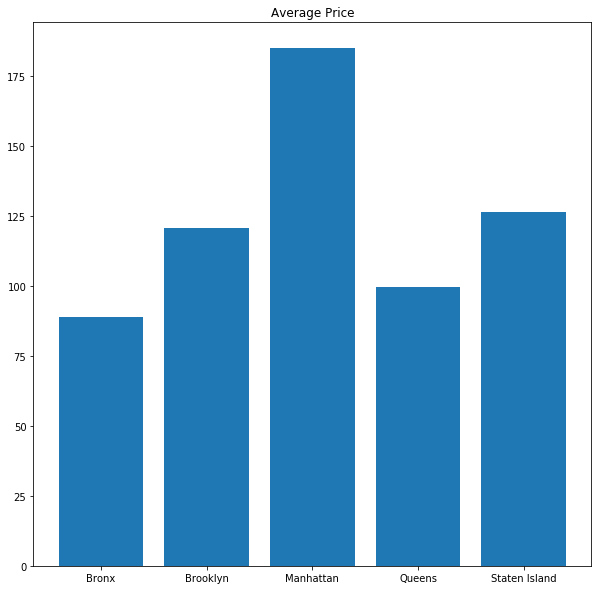

In [82]:
# Price
price_group = ls[["neighbourhood_group","price","reviews_per_month"]].groupby(["neighbourhood_group"]).price.mean()
plt.figure(figsize = (10,10))
plt.bar(range(len(price_group.values)),price_group.values)
plt.xticks(range(len(price_group.values)),list(price_group.index))
plt.title("Average Price");

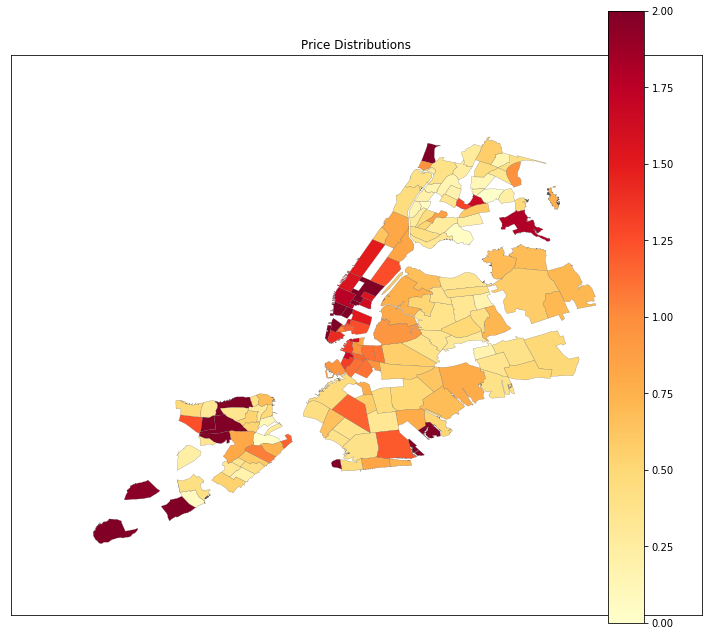

In [110]:
# Price Geometry Distribution 

prices = listings_detail[["neighbourhood","price","reviews_per_month"]].groupby(["neighbourhood"]).price.mean()
priceMap = dict(prices)

max_ = max(priceMap.values())
min_ = min(priceMap.values())
def norm_transform(price):
    return (price-min_)/( 250 - min_)#Hard Coding Truncature Here at 250 USD here to see a more meaningful result

###############SET UP LIMITS#########################
mp = nbgeo.geometry.loc[101]
cm = plt.get_cmap('YlOrRd')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = mp.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 20 * w, maxx + 5 * w)
ax.set_ylim(miny - 10 * h, maxy + 8 * h)
ax.set_aspect(1)

###############ADD NEIGHBOURS#########################
for i in range(len(nbgeo.geometry)):
    patches = []
    mp = nbgeo.geometry.loc[i]
    nb = nbgeo.neighbourhood.loc[i]
    try:
        price = priceMap[nb]
    except:
        continue
    for idx, p in enumerate(mp):
        colour = cm(norm_transform(price))
        patches.append(PolygonPatch(p, fc=colour, ec='#555555', lw=0.2, alpha=1., zorder=1))
        ax.add_collection(PatchCollection(patches, match_original=True))

###############DRAW##################################
ax.set_xticks([])
ax.set_yticks([])
plt.title("Price Distributions")
plt.tight_layout()
## need to get color bar correct
##ax2  = fig.add_axes([0.85,0.10,0.05,0.85])
##norm = mpl.colors.Normalize(vmin=0,vmax=2)
##cb1  = mpl.colorbar.ColorbarBase(ax2,cmap=cm,norm=norm,orientation='vertical')

plt.show()

#### Popularity
We are defining popularity in terms of availibilty, meaning more popular airbnb's have less availability and less popular ones have more

### Question 2: 
Do factors such as number of minimum nights, cancellation policy, instant bookable, and house rules affect the popularity of an Airbnb?

### Question 3: 
How important are reviews and how much do they affect whether or not an Airbnb gets booked?

### Question 4: 
Do amenities, access (entire apartment vs private room), room type (private vs shared), transit, or number of guests significantly impact whether or not an Airbnb is booked?

### Visualize Data on Map
- What areas are most popular? why?

#### Number of Airbnbs by Neighbourhood

In [89]:
#Use host id since there are no missing - meaning we get every record when counting
ls['host_id'].groupby(ls['neighbourhood_group']).count()

neighbourhood_group
Bronx              791
Brooklyn         18470
Manhattan        20370
Queens            4392
Staten Island      294
Name: host_id, dtype: int64

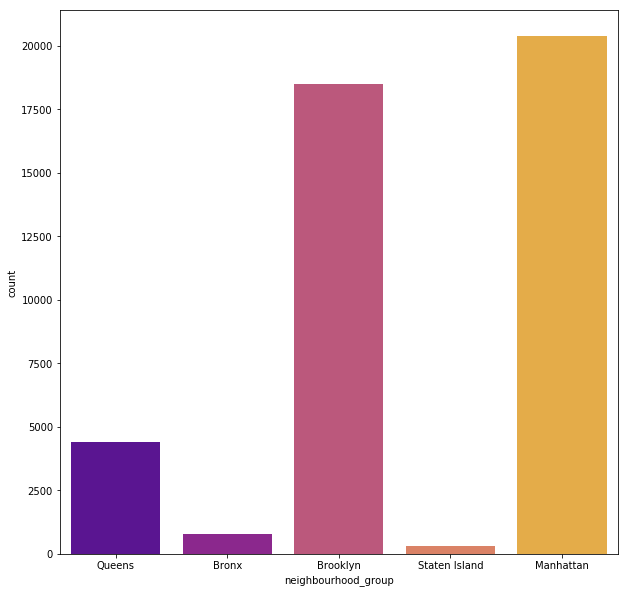

In [90]:
#https://www.kaggle.com/darkrubiks/nyc-airbnb-exploratory-analysis
#Amount of Airbnbs by borough
plt.figure(figsize=(10,10))
ax = sns.countplot(ls["neighbourhood_group"], palette="plasma" ) 

Things to explore later

In [86]:
ld=listing_details[['guests_included','extra_people','minimum_nights','listing_url','house_rules','cancellation_policy','instant_bookable','amenities','price','weekly_price','monthly_price','room_type','neighbourhood','reviews_per_month','longitude','latitude']]

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

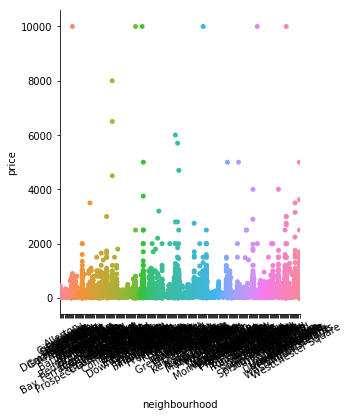

In [42]:
g=sns.catplot(x = "neighbourhood", y = "price", data=ls)
g.set_xticklabels(rotation=30)
#sns.set(rc={'figure.figsize':(40,20)})
